In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tqdm import tqdm  # Progress bar

data = pd.read_csv('data/pro-football-reference.csv',index_col=0)
qbs = pd.read_csv('data/FantasyPros_Fantasy_Football_Projections_QB.csv')
wrs = pd.read_csv('data/FantasyPros_Fantasy_Football_Projections_WR.csv')
tes = pd.read_csv('data/FantasyPros_Fantasy_Football_Projections_TE.csv')
rbs = pd.read_csv('data/FantasyPros_Fantasy_Football_Projections_RB.csv')

projections = pd.concat([qbs,wrs,tes,rbs], ignore_index=False)

data['Player'] = data['Player'].str.strip('+')
data['Player'] = data['Player'].str.strip('*')
projections = projections.dropna(how='all')

projections

,Player,Team,ATT,CMP,YDS,TDS,INTS,ATT.1,YDS.1,TDS.1,FL,FPTS,REC
0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lamar Jackson,BAL,468.4,312.7,"3,844.0",31.8,8.1,134.3,812.3,4.0,4.3,369.6,NaN
2,Josh Allen,BUF,507.5,324.9,"3,824.1",28.4,10.3,112.5,559.0,10.4,3.2,368.1,NaN
3,Jalen Hurts,PHI,447.6,301.8,"3,409.6",23.0,8.6,144.2,621.5,12.4,3.7,348.8,NaN
4,Jayden Daniels,WAS,522.9,355.3,"3,815.0",26.2,10.4,132.2,727.2,5.4,2.4,347.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Jawhar Jordan,HOU,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
181,Louis Rees-Zammit,JAC,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
182,Michael Wiley,WAS,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
183,Kendall Milton,CIN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [3]:
merged_df = pd.merge(left=data, right=projections, on='Player', how='left')
merged_df['YDS'] = merged_df['YDS'].replace(',', '', regex=True).astype(float)
merged_df

,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,TD,...,CMP,YDS,TDS,INTS,ATT.1,YDS.1,TDS.1,FL_y,FPTS,REC
0,Saquon Barkley,PHI,RB,27,16,16,0.0,0.0,0.0,0.0,...,NaN,1584.6,10.4,NaN,NaN,274.0,1.9,1.4,257.3,35.9
1,Derrick Henry,BAL,RB,30,17,17,0.0,0.0,0.0,0.0,...,NaN,1501.4,13.4,NaN,NaN,161.2,1.0,1.4,249.4,17.1
2,Jahmyr Gibbs,DET,RB,22,17,4,0.0,0.0,0.0,0.0,...,NaN,1223.2,11.6,NaN,NaN,462.7,2.6,1.3,251.3,52.4
3,Lamar Jackson,BAL,QB,27,17,17,316.0,474.0,4172.0,41.0,...,312.7,3844.0,31.8,8.1,134.3,812.3,4.0,4.3,369.6,NaN
4,Ja'Marr Chase,CIN,WR,24,17,16,0.0,0.0,0.0,0.0,...,NaN,1506.4,11.8,NaN,NaN,11.5,0.0,0.6,221.4,116.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,Dylan Laube,LVR,RB,25,10,0,0.0,0.0,0.0,0.0,...,NaN,8.3,0.0,NaN,NaN,7.3,0.0,0.0,1.6,1.0
627,Steven Sims,2TM,WR,27,9,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,Kadarius Toney,CLE,WR,25,3,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,Clayton Tune,ARI,QB,25,6,0,2.0,2.0,8.0,0.0,...,4.3,68.8,0.5,0.3,1.7,3.5,0.0,0.3,4.2,NaN


In [4]:
merged_df.columns

Index(['Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD',
       'Int', 'Att.1', 'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
       'TD.2', 'Fmb', 'FL_x', 'TD.3', '2PM', '2PP', 'FantPt', 'PPR', 'DKPt',
       'FDPt', 'VBD', 'PosRank', 'OvRank', '-9999', 'Team', 'ATT', 'CMP',
       'YDS', 'TDS', 'INTS', 'ATT.1', 'YDS.1', 'TDS.1', 'FL_y', 'FPTS', 'REC'],
      dtype='object')

In [5]:


# Drop irrelevant or duplicate columns
drop_cols = ['Player', 'Tm', 'Team', '-9999', 'FantPt', 'PPR', 'DKPt', 'FDPt', 'FPTS']  # Drop target and non-predictive
X = merged_df.drop(columns=drop_cols)
y = merged_df['FPTS']

# Handle missing values
X.fillna(0, inplace=True)

# Optional: One-hot encode categorical variables
X = pd.get_dummies(X, columns=['FantPos'], drop_first=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Impute missing values in y_train
imputer_y = SimpleImputer(strategy='mean')
y_train_imputed = imputer_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Fit the model
lr = LinearRegression()
lr.fit(X_train, y_train_imputed)

# Impute missing values in y_test
y_test_imputed = imputer_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Predict and evaluate
y_pred = lr.predict(X_test)
print("Linear Regression R²:", r2_score(y_test_imputed, y_pred))
print("MSE:", mean_squared_error(y_test_imputed, y_pred))


Linear Regression R²: 0.9186125016092052
MSE: 381.65673455806694


Random Forest R²: 0.9593005124874981
MSE: 190.85209226676443


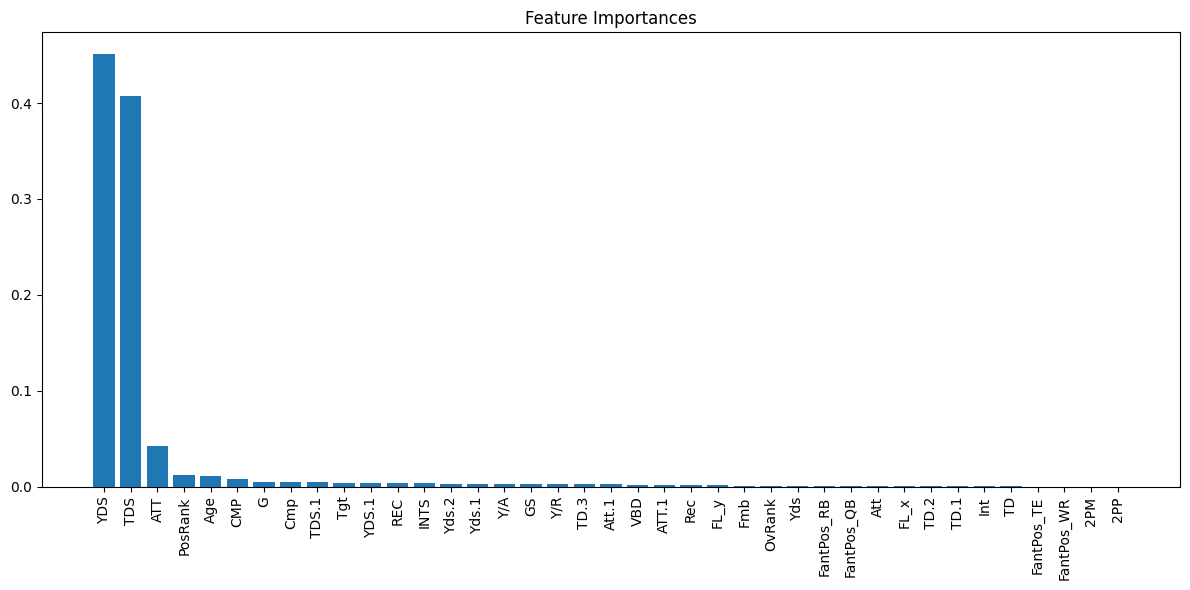

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Impute missing values in y
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_imputed, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Random Forest R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [9]:



xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("MSE:", mean_squared_error(y_test, y_pred_xgb))


XGBoost R²: 0.9618339537581917
MSE: 178.97202702028417


In [10]:
# Impute missing values in y
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Store predictions
n_runs = 1
all_preds = np.zeros((X.shape[0], n_runs))

# Loop with progress bar
for i in tqdm(range(n_runs), desc="Running Random Forest Ensemble"):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_imputed, test_size=0.2, random_state=i)
    rf = RandomForestRegressor(n_estimators=100, random_state=i)
    rf.fit(X_train, y_train)
    all_preds[:, i] = rf.predict(X_scaled)

# Average predictions
avg_preds = all_preds.mean(axis=1)

# Attach to DataFrame
merged_df['Predicted_FPTS'] = avg_preds

# Display top players
print(merged_df[['Player', 'FantPos', 'Predicted_FPTS']].sort_values(by='Predicted_FPTS', ascending=False).head(10))

Running Random Forest Ensemble:   0%|          | 0/1 [00:00<?, ?it/s]

Running Random Forest Ensemble: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

             Player FantPos  Predicted_FPTS
3     Lamar Jackson      QB         358.606
7        Josh Allen      QB         352.160
15   Jayden Daniels      QB         344.589
38      Jalen Hurts      QB         335.771
107   Justin Fields      QB         309.641
57     Kyler Murray      QB         305.401
37           Bo Nix      QB         303.757
74      Brock Purdy      QB         292.787
8        Joe Burrow      QB         283.288
12   Baker Mayfield      QB         281.261


In [11]:
# Ensure 'FantPos' column exists and is clean
positions = ['QB', 'RB', 'WR', 'TE']

# Create a dictionary of position-specific DataFrames
position_dfs = {pos: merged_df[merged_df['FantPos'] == pos].copy() for pos in positions}

# Optional: sort each by predicted fantasy points
for pos in positions:
    position_dfs[pos] = position_dfs[pos].sort_values(by='Predicted_FPTS', ascending=False).reset_index(drop=True)

# Access examples
qb_df = position_dfs['QB']
rb_df = position_dfs['RB']
wr_df = position_dfs['WR']
te_df = position_dfs['TE']


In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Dictionary of position DataFrames
position_dfs = {
    'QB': qb_df,
    'RB': rb_df,
    'WR': wr_df,
    'TE': te_df
}

# Correct feature columns per position
position_features = {
    'QB': ['Age', 'ATT', 'Cmp', 'Yds', 'TD', 'Int'],
    'RB': ['Age', 'ATT.1', 'YDS.1', 'TDS.1', 'REC'],
    'WR': ['Age', 'Tgt', 'Rec', 'Yds.2', 'TD.2'],
    'TE': ['Age', 'Tgt', 'Rec', 'Yds.2', 'TD.2']
}

# Store results
xgb_results = {}

for pos, df in position_dfs.items():
    features = position_features[pos]

    # Drop rows with missing values in required columns
    df = df.dropna(subset=features + ['FPTS']).copy()

    X = df[features]
    y = df['FPTS']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)



    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, y_pred)

    xgb_results[pos] = {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred,
        'actuals': y_test,
        'features': features
    }

    print(f"{pos} — RMSE: {rmse:.2f}, R²: {r2:.2f}")


QB — RMSE: 48.06, R²: 0.89


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
for pos in xgb_results:
    model = xgb_results[pos]['model']
    features = xgb_results[pos]['features']

    plt.figure(figsize=(6, 4))
    plt.barh(features, model.feature_importances_)
    plt.title(f"{pos} Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


KeyError: ['Targets', 'Receptions', 'Yards', 'TDs']